In [26]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.colors import ListedColormap, BoundaryNorm
import shapely.geometry as sgeom
from shapely.geometry import Point
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.lines as mlines
import Topography
from shapely.vectorized import contains
import matplotlib.ticker as mticker

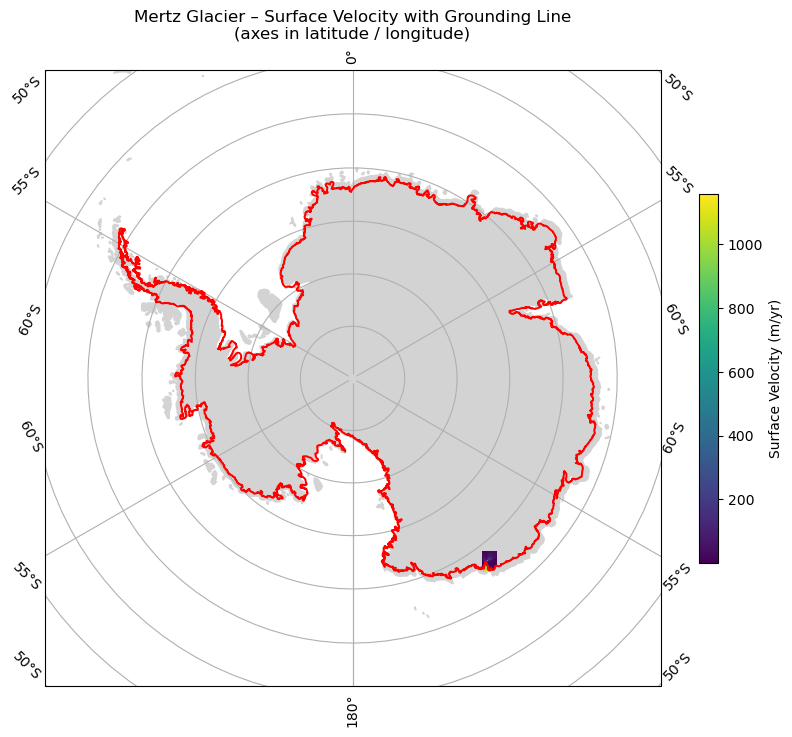

In [44]:
xmin_ant = -3333250
xmax_ant = 3333250
ymin_ant = -3333250
ymax_ant = 3333250

xmin, xmax = 1382750/1000, 1543250/1000
ymin, ymax = -2077750/1000, -1850250/1000

path = "/Users/maheerbansari/Downloads/CURE_Geophysical/DEMOGORGN data/moa2014_groundingline_v01/moa2014_grounding_line_v01.shp"
gl = gpd.read_file(path)
glx,gly = gl.geometry[0].exterior.xy
glau = gl.geometry.clip_by_rect(xmin_ant, ymin_ant, xmax_ant, ymax_ant)
glaux, glauy = glau[0].exterior.xy


# Extract all polygons into lists of x/y coordinates
glaux_list = []
glauy_list = []

for geom in glau.geometry:
    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        glaux_list.append(np.array(x))
        glauy_list.append(np.array(y))
    elif geom.geom_type == 'MultiPolygon':
        for poly in geom.geoms:
            x, y = poly.exterior.xy
            glaux_list.append(np.array(x))
            glauy_list.append(np.array(y))


df = pd.read_csv('MertzGlacierDataGridded.csv')
xx, yy = np.meshgrid(np.unique(df.x), np.unique(df.y))

velocity_x = df['velx'].values.reshape(xx.shape)
velocity_y = df['vely'].values.reshape(xx.shape)
surface_mass_balance = df['smb'].values.reshape(xx.shape) #smb = surface mass balance
surface_elevation_change = df['dhdt'].values.reshape(xx.shape) #dhdt = surface elevation change rate
velocity_magnitude = np.sqrt(velocity_x**2 + velocity_y**2)
bedmap_surf = df['surf'].values.reshape(xx.shape)

# --- CARTOPY FIGURE SETUP ---
fig = plt.figure(figsize=(10, 8))

# Antarctic Polar Stereographic
proj = ccrs.SouthPolarStereo()

ax = plt.axes(projection=proj)

# Set extent using stereographic x/y coordinates (meters)
ax.set_extent([-3.3e6, 3.3e6, -3.3e6, 3.3e6], crs=proj)

# Add coastlines + background context
ax.add_feature(cfeature.LAND, color="lightgray")
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)


# --- PLOT VELOCITY MAGNITUDE ---
img = ax.pcolormesh(
    xx, yy, velocity_magnitude,
    cmap="viridis",
    transform=proj,
    shading='auto'
)


# --- OVERLAY GROUNDING LINE (already EPSG:3031) ---
for gx, gy in zip(glaux_list, glauy_list):
    ax.plot(gx, gy, color='red', linewidth=1.4, transform=proj)


# --- COLORBAR ---
cbar = plt.colorbar(img, ax=ax, shrink=0.6)
cbar.set_label("Surface Velocity (m/yr)")

plt.title("Mertz Glacier – Surface Velocity with Grounding Line\n(axes in latitude / longitude)")
plt.show()

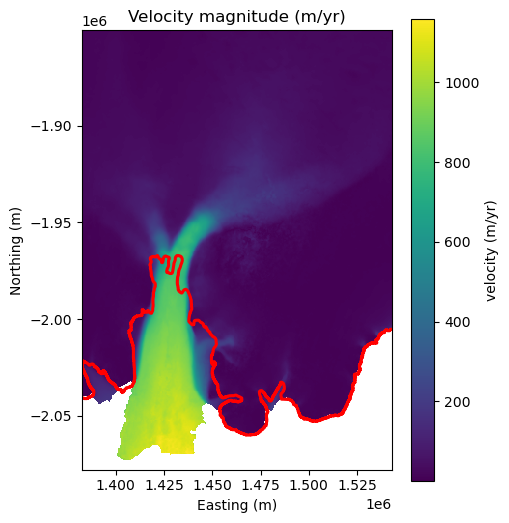

In [39]:
# calculate velocity magnitude
vel_mag = velocity_magnitude

# bounding box of your plot area
xmin, xmax = xx.min(), xx.max()
ymin, ymax = yy.min(), yy.max()

# plot velocity
plt.figure(figsize=(5, 6))
p = plt.pcolormesh(xx, yy, vel_mag, shading='auto')

# colorbar
cbar = plt.colorbar(p)
cbar.set_label("velocity (m/yr)")

# ---- CROP GROUNDING LINE TO STUDY AREA ----
for gx, gy in zip(glaux_list, glauy_list):

    # create inside-mask (True where grounding line falls inside domain)
    inside = (gx >= xmin) & (gx <= xmax) & (gy >= ymin) & (gy <= ymax)

    if np.any(inside):
        plt.plot(gx[inside], gy[inside], color='red', linewidth=2.2)

plt.axis('scaled')
plt.title('Velocity magnitude (m/yr)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.show()

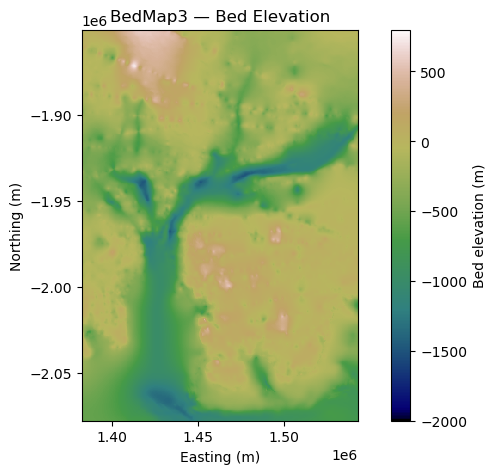

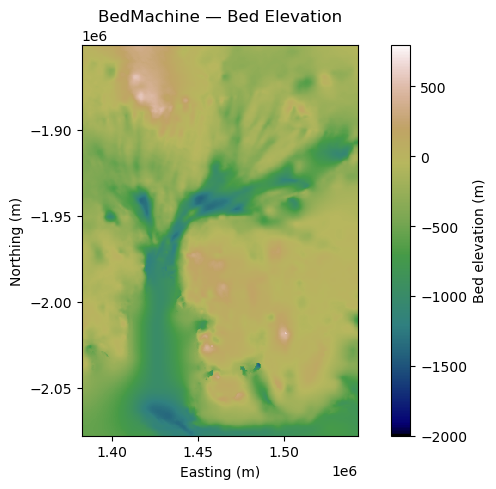

In [8]:
plt.figure(figsize=(5, 5))
bedmap_bed=df['bedmap_bed'].values.reshape(xx.shape)
p1 = plt.pcolormesh(xx, yy, bedmap_bed, cmap='gist_earth',
                    shading='nearest', vmin=-2000, vmax=800)

cbar = plt.colorbar(p1)
cbar.set_label("Bed elevation (m)")

plt.axis('scaled')
plt.title("BedMap3 — Bed Elevation")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
bm_bed=df['bm_bed'].values.reshape(xx.shape)
p2 = plt.pcolormesh(xx, yy, bm_bed, cmap='gist_earth',
                    shading='nearest', vmin=-2000, vmax=800)

cbar = plt.colorbar(p2)
cbar.set_label("Bed elevation (m)")

plt.axis('scaled')
plt.title("BedMachine — Bed Elevation")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.tight_layout()
plt.show()

/var/folders/1x/4c8mjfmx43n5v6fq6xlrc7200000gn/T/ipykernel_64597/601238506.py:31: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  is_grounded_or_land = contains(gl_polygon, X_flat, Y_flat).reshape(xx.shape)


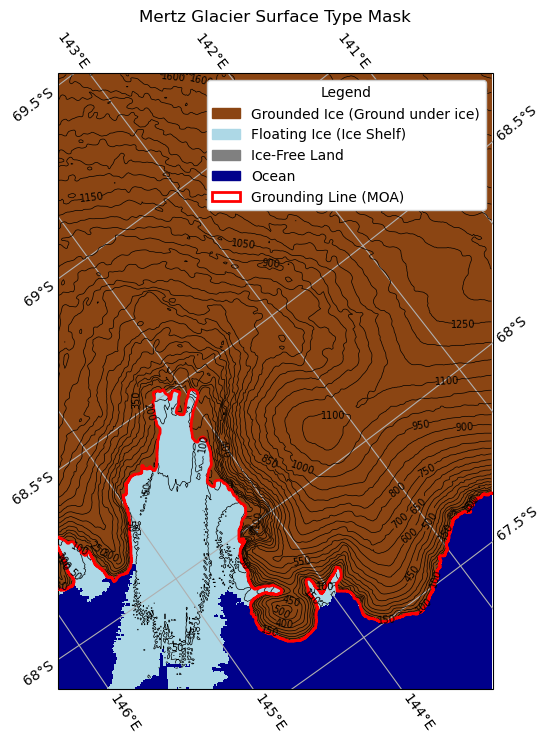

In [46]:
# Direct Calculation of Ice Thickness (H)
H = surf - bm_bed
    
H_min = 10 # Minimum ice thickness threshold (m)

# --- 2. GROUNDING LINE (MOA) SETUP ---
path = "/Users/maheerbansari/Downloads/CURE_Geophysical/DEMOGORGN data/moa2014_groundingline_v01/moa2014_grounding_line_v01.shp"
gl = gpd.read_file(path)

# Clip the MOA data to the Antarctic extent
xmin_ant = -3333250
xmax_ant = 3333250
ymin_ant = -3333250
ymax_ant = 3333250
glau = gl.geometry.clip_by_rect(xmin_ant, ymin_ant, xmax_ant, ymax_ant)


# --- Consolidate clipped MOA polygons into a single Shapely object for spatial masking ---
# Using union_all()
gl_union = glau.geometry.union_all() 
if gl_union.geom_type == 'Polygon':
    gl_polygon = gl_union
elif gl_union.geom_type == 'MultiPolygon':
    gl_polygon = gl_union

# Flatten the gridded coordinates for the `contains` test
X_flat = xx.flatten()
Y_flat = yy.flatten()

# Spatial containment test: True where the point is INSIDE the MOA polygon (Grounded Ice/Land)
is_grounded_or_land = contains(gl_polygon, X_flat, Y_flat).reshape(xx.shape)


# --- 3. DEFINE THE GLACIER MASK ---
# Initialize mask: 0 = Ocean/default
glacier_mask = np.zeros(xx.shape) 

# A. Grounded Ice (Code 3)
grounded_ice_condition = is_grounded_or_land & (H > H_min)
glacier_mask[grounded_ice_condition] = 3

# B. Floating Ice (Code 2)
floating_ice_condition = (~is_grounded_or_land) & (H > H_min)
glacier_mask[floating_ice_condition] = 2

# C. Non-Ice Areas (H <= H_min)
non_ice_areas = H <= H_min

# 1. Ice-Free Land (Code 1)
ice_free_land_condition = non_ice_areas & (bm_bed >= 0) & is_grounded_or_land
glacier_mask[ice_free_land_condition] = 1

# 0. Ocean (Code 0) - Default


# --- 4. CARTOPY FIGURE SETUP AND PLOT ---
fig = plt.figure(figsize=(10, 8))
proj = ccrs.SouthPolarStereo()
ax = plt.axes(projection=proj)
ax.set_extent([xmin, xmax, ymin, ymax], crs=proj)
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

# Define colors for the regimes (Updated Colors): 
# 0=Ocean (darkblue), 1=Ice-Free Land (gray), 2=Floating Ice (lightblue), 3=Grounded Ice (saddlebrown)
colors = ['darkblue', 'gray', 'lightblue', 'saddlebrown']
cmap = ListedColormap(colors)
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# Plot Glacier Mask
img = ax.pcolormesh(
    xx, yy, glacier_mask,
    cmap=cmap,
    norm=norm,
    transform=proj,
    shading='auto',
    zorder=1
)

# Plot MOA Grounding Line Boundary (Solid Red Line)
for geom in glau.geometry:
    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        ax.plot(x, y, color='red', linestyle='-', linewidth=2.0, transform=proj, zorder=3)
    elif geom.geom_type == 'MultiPolygon':
        for poly in geom.geoms:
            x, y = poly.exterior.xy
            ax.plot(x, y, color='red', linestyle='-', linewidth=2.0, transform=proj, zorder=3)

# Overlay Surface Elevation Contours (Black Lines)
contour_levels = np.arange(np.floor(np.nanmin(surf)/50)*50, np.ceil(np.nanmax(surf)/50)*50, 50)
contours = ax.contour(
    xx, yy, surf,
    levels=contour_levels,
    colors='black', 
    linewidths=0.5,
    transform=proj,
    zorder=2
)
ax.clabel(contours, inline=True, fontsize=7, fmt='%1.0f')


# --- 5. CUSTOM LEGEND (WARNING FIXED HERE) ---
legend_patches = [
    mpatches.Patch(color=colors[3], label='Grounded Ice (Ground under ice)'),
    mpatches.Patch(color=colors[2], label='Floating Ice (Ice Shelf)'),
    mpatches.Patch(color=colors[1], label='Ice-Free Land'),
    mpatches.Patch(color=colors[0], label='Ocean')
]
# FIX: Use facecolor='none' instead of color='none' to suppress the UserWarning
gl_patch = mpatches.Patch(facecolor='none', edgecolor='red', linewidth=2.0, label='Grounding Line (MOA)')
legend_patches.append(gl_patch)

# Legend location and title updated as requested:
ax.legend(
    handles=legend_patches, 
    loc='upper right', # Changed location to upper right
    title='Legend',
    framealpha=1
)
plt.title("Mertz Glacier Surface Type Mask")
plt.show()